In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y, ode_y_parallel
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
def simulation(y_grid, e_grid, h_grid, g_grid, θ=1.86/1000.,
               y_start=.5394, T=100, dt=1):
    Et = np.zeros(int(T/dt)+1)
    yt = np.zeros(int(T/dt)+1)
    ht = np.zeros(int(T/dt)+1)
    gt = np.zeros((len(g_grid), int(T/dt)+1))
    for i in range(int(T/dt)+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ht[i] = np.interp(y_start, y_grid, h_grid)
        for n in range(gt.shape[0]):
            gt[n, i] = np.interp(y_start, y_grid, g_grid[n])
        yt[i] = y_start
        y_start = y_start + Et[i]*θ*dt
    return Et, yt, ht, gt

## Solve HJB

In [142]:
# Intensity parameter
τ = .25

r1 = 19.5001
r0 = .4

# Robustness parameters
ξ_b = 100000.
ξ_p = 100000.
ξ_a = 100000.

n_model = 3
# damage_setting={'γ_2p': np.linspace(0, 1./3, n_model),
#                 'πd_o': np.ones(n_model)/n_model}
damage_setting={'γ_2p': np.linspace(0, 1./100, n_model),
                'πd_o': np.ones(n_model)/n_model}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.5

# Grid setting
ϵ = 2.
y_step = .01
y_grid_long = np.arange(0., y_bar_upper*2+y_step, y_step)
y_grid_short = np.arange(0., y_bar_upper+y_step, y_step)
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper)
y_grid_tilde = y_grid_short[y_bar_lower_loc: y_bar_upper_loc+1]

In [143]:
# Parallelly solve ODE
model_args_list = []
model_list = []

for i in range(n_model):
    temp_list = []
    for y_jump in y_grid_tilde:
        temp = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_a, γ_1, γ_2, γ_2p[i], y_jump)
        temp_list.append((y_grid_long, temp, None, ϵ, 1e-8, 2000, False))
    model_args_list.append(temp_list)

for i in range(n_model):
    print('-----Solving model ' + str(i) + '-----')
    temp_res = ode_y_parallel(model_args_list[i])
    model_list.append(temp_res)

-----Solving model 0-----
-----Solving model 1-----
-----Solving model 2-----


In [144]:
# Prepare ϕ_m
ϕ_m = np.zeros((n_model, len(y_grid_short)))
e_m = np.zeros((n_model, len(y_grid_short)))
for i in range(len(y_grid_tilde)):
    for j in range(n_model):
        ϕ_m[j, y_bar_lower_loc+i] = model_list[j][i]['v0'][y_bar_lower_loc+i]
        e_m[j, y_bar_lower_loc+i] = model_list[j][i]['e_tilde'][y_bar_lower_loc+i]

# Prepare v_guess
v_guess = np.average(np.array([model_list[i][-1]['v0'][:y_bar_upper_loc+1] for i in range(len(model_list))]),
                     weights=np.ones(len(model_list))/len(model_list), axis=0)

In [145]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, τ = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = - η * (y_grid + y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    intensity = - r0 * (np.exp(- r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
                + 0 * (y_grid < y_bar_lower)

#     intensity = 0.75 * (y_grid - 1.5) * (y_grid > 1.5) + 300 * (y_grid - 1.9)**2 * (y_grid > 1.9)

#     r1_test = 5.
#     r0_test = 1.
#     intensity = r0_test * (np.exp(r1_test / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
#                 + 0 * (y_grid < y_bar_lower)
    
#     ς = .5
#     intensity = 1./np.sqrt(ς)*np.exp(-(y_bar_upper-y_grid)**2/(2*ς**2))
    
    bc = -ξ_2m * np.log(np.sum(πd_o[:, -1] * np.exp(-1./ξ_2m * ϕ_i[:, -1])))

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)

        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5
 
        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

#         g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

#         A = np.ones_like(y_grid)*(-δ)
#         B = e_tilde * np.sum(πc*θ, axis=0)
#         C = .5 * σ_y**2 * e_tilde**2
#         D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
#             + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
#             - ξ_2m * intensity * (np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0)- np.exp(-1./ξ_2m * v0)) \
#                 / np.exp(-1./ξ_2m * v0)


#         g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

#         A = np.ones_like(y_grid)*(-δ)
#         B = e_tilde * np.sum(πc*θ, axis=0)
#         C = .5 * σ_y**2 * e_tilde**2
#         D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
#             + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
#             + intensity * np.sum(g * πd_o * (ϕ_m - v0), axis=0)\
#             + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)


        g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

        A = np.ones_like(y_grid)*(-δ) - intensity * np.sum(πd_o * g, axis=0)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)\
            + intensity * np.sum(πd_o * g * ϕ_i, axis=0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, bc), (False, True))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    πd = g / np.sum(πd_o * g, axis=0) * πd_o
    
    
    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'πc': πc,
           'πd': πd,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [146]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, τ)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=1,
                                          tol=1e-8, max_iter=2000, print_all=True)

Iteration 1: LHS Error: 0.023753400415333914; RHS Error 0.023864510077792223
Iteration 2: LHS Error: 0.015546038641516269; RHS Error 0.015849226162649832
Iteration 3: LHS Error: 0.01248055211324317; RHS Error 0.01293104570591197
Iteration 4: LHS Error: 0.010755612905855472; RHS Error 0.011338007761992785
Iteration 5: LHS Error: 0.009593068654889514; RHS Error 0.010212397577720855
Iteration 6: LHS Error: 0.008759961864066135; RHS Error 0.009446716470674188
Iteration 7: LHS Error: 0.008146495147509647; RHS Error 0.00881684711357808
Iteration 8: LHS Error: 0.007659167941733713; RHS Error 0.008262668758660802
Iteration 9: LHS Error: 0.0072582797879414684; RHS Error 0.0077876412447355214
Iteration 10: LHS Error: 0.006919593514203015; RHS Error 0.007351035263033295
Iteration 11: LHS Error: 0.006626732179241479; RHS Error 0.006939164173950602
Iteration 12: LHS Error: 0.006353159367421313; RHS Error 0.006550432094653766
Iteration 13: LHS Error: 0.0060995499099965045; RHS Error 0.00618298457447

Iteration 111: LHS Error: 0.00010323732960948462; RHS Error 0.0012809052900961682
Iteration 112: LHS Error: 9.08061094602175e-05; RHS Error 0.0012764871739632255
Iteration 113: LHS Error: 7.972088427354862e-05; RHS Error 0.0012764603779260586
Iteration 114: LHS Error: 6.982191915483327e-05; RHS Error 0.0012789058924516095
Iteration 115: LHS Error: 6.10994285485944e-05; RHS Error 0.0012784331329718235
Iteration 116: LHS Error: 5.330699657513094e-05; RHS Error 0.0012998043975580575
Iteration 117: LHS Error: 4.643242308244311e-05; RHS Error 0.0012788081625552117
Iteration 118: LHS Error: 4.039755020457392e-05; RHS Error 0.0012887311855647177
Iteration 119: LHS Error: 3.508321649903223e-05; RHS Error 0.0012831700351849662
Iteration 120: LHS Error: 3.0398755670901778e-05; RHS Error 0.001288119930896503
Iteration 121: LHS Error: 2.6323244663117862e-05; RHS Error 0.0012760326307270642
Iteration 122: LHS Error: 2.2744082118997255e-05; RHS Error 0.0012812856398052297
Iteration 123: LHS Error: 1

Iteration 221: LHS Error: 1.1213535191068047e-05; RHS Error 0.0012828274963614383
Iteration 222: LHS Error: 8.181182551858512e-06; RHS Error 0.001280156193790516
Iteration 223: LHS Error: 5.500524014045993e-06; RHS Error 0.0012794781310405678
Iteration 224: LHS Error: 2.427188779474676e-05; RHS Error 0.0012770174502640952
Iteration 225: LHS Error: 2.0486064728153508e-05; RHS Error 0.0012718654492132053
Iteration 226: LHS Error: 1.5358452915670284e-05; RHS Error 0.0012738692900111648
Iteration 227: LHS Error: 9.449913021875034e-06; RHS Error 0.0012848984022779675
Iteration 228: LHS Error: 2.3857186004505593e-06; RHS Error 0.0012787971718115632
Iteration 229: LHS Error: 1.2117153075585918e-05; RHS Error 0.0012769374066667893
Iteration 230: LHS Error: 1.5342529365192092e-05; RHS Error 0.0012727780240853193
Iteration 231: LHS Error: 3.0151528692456964e-05; RHS Error 0.001279387067690374
Iteration 232: LHS Error: 1.676931025240691e-05; RHS Error 0.0012756956071917624
Iteration 233: LHS Erro

Iteration 332: LHS Error: 3.144732118265381e-05; RHS Error 0.0012976772174866369
Iteration 333: LHS Error: 3.839090926671673e-05; RHS Error 0.00128400316873023
Iteration 334: LHS Error: 7.047312994501453e-05; RHS Error 0.001278923628956763
Iteration 335: LHS Error: 2.997454713860037e-05; RHS Error 0.0012936838967152475
Iteration 336: LHS Error: 3.4181229757734855e-06; RHS Error 0.0012813202355088649
Iteration 337: LHS Error: 1.258021688155253e-05; RHS Error 0.001280101833392111
Iteration 338: LHS Error: 3.964997751015886e-05; RHS Error 0.0012816695122614963
Iteration 339: LHS Error: 1.6944625332193652e-05; RHS Error 0.0012930562306638915
Iteration 340: LHS Error: 9.649525024357786e-06; RHS Error 0.0012787509613851888
Iteration 341: LHS Error: 2.8002019521800037e-05; RHS Error 0.0012764042080233295
Iteration 342: LHS Error: 3.01066445267395e-05; RHS Error 0.0012848606045969824
Iteration 343: LHS Error: 2.189845351807662e-05; RHS Error 0.0012735222801283363
Iteration 344: LHS Error: 6.91

Iteration 442: LHS Error: 1.4849375379100138e-05; RHS Error 0.0012729339219277325
Iteration 443: LHS Error: 5.90386069330151e-05; RHS Error 0.0012649689943315945
Iteration 444: LHS Error: 3.983067746204938e-05; RHS Error 0.001294486347336532
Iteration 445: LHS Error: 5.09857492332344e-05; RHS Error 0.0012816071383170424
Iteration 446: LHS Error: 3.601630664284983e-05; RHS Error 0.0012991653060350217
Iteration 447: LHS Error: 3.654336444380846e-05; RHS Error 0.0012910438839481841
Iteration 448: LHS Error: 2.0402525644058755e-05; RHS Error 0.0012891256186016165
Iteration 449: LHS Error: 2.0008559088680045e-05; RHS Error 0.0012678458821102634
Iteration 450: LHS Error: 3.665541084174606e-05; RHS Error 0.0012562780725728917
Iteration 451: LHS Error: 0.00011583367631562425; RHS Error 0.0012594237735754632
Iteration 452: LHS Error: 8.226458884408316e-05; RHS Error 0.0013073844857249828
Iteration 453: LHS Error: 2.268479306355431e-05; RHS Error 0.0012948619317245669
Iteration 454: LHS Error: 2

Iteration 552: LHS Error: 2.4178335316982213e-05; RHS Error 0.0012736638741388528
Iteration 553: LHS Error: 2.69789160114442e-05; RHS Error 0.0012802305093624344
Iteration 554: LHS Error: 1.8437804486737264e-05; RHS Error 0.0012648673372304131
Iteration 555: LHS Error: 8.74303741493776e-06; RHS Error 0.0012712470434603773
Iteration 556: LHS Error: 5.311778321193117e-06; RHS Error 0.0012790571920238136
Iteration 557: LHS Error: 7.508826275426372e-06; RHS Error 0.0012757750072549534
Iteration 558: LHS Error: 3.39357879042268e-06; RHS Error 0.0012787480824980602
Iteration 559: LHS Error: 3.866698254917367e-06; RHS Error 0.0012778674627105246
Iteration 560: LHS Error: 2.5579163833278074e-05; RHS Error 0.001277021001409473
Iteration 561: LHS Error: 1.835340408984365e-05; RHS Error 0.0012716627181019735
Iteration 562: LHS Error: 1.4714787259784146e-05; RHS Error 0.0012756955099195721
Iteration 563: LHS Error: 1.0292924147670135e-05; RHS Error 0.0012789781823947521
Iteration 564: LHS Error: 2

Iteration 662: LHS Error: 1.6543711293337537e-05; RHS Error 0.0012782129701762734
Iteration 663: LHS Error: 8.82178304006942e-06; RHS Error 0.0012853630306064456
Iteration 664: LHS Error: 2.6763618881986417e-05; RHS Error 0.0012922541881774663
Iteration 665: LHS Error: 1.623461513933222e-05; RHS Error 0.0012916100921327445
Iteration 666: LHS Error: 3.373760081171184e-05; RHS Error 0.0012846328606679336
Iteration 667: LHS Error: 9.247869628303818e-06; RHS Error 0.0012831044490737575
Iteration 668: LHS Error: 2.578788767415574e-05; RHS Error 0.0012789581606909017
Iteration 669: LHS Error: 3.908251589024303e-05; RHS Error 0.0012824365977850416
Iteration 670: LHS Error: 2.193963669050447e-05; RHS Error 0.001284704074409726
Iteration 671: LHS Error: 1.3183872478172987e-05; RHS Error 0.0012843865349498884
Iteration 672: LHS Error: 2.646437084852238e-05; RHS Error 0.001279497270826102
Iteration 673: LHS Error: 1.2205513596263984e-05; RHS Error 0.0012830294336212411
Iteration 674: LHS Error: 2

Iteration 772: LHS Error: 2.2692231644860783e-05; RHS Error 0.0012790929387103134
Iteration 773: LHS Error: 8.761744142660177e-06; RHS Error 0.0012858207994330684
Iteration 774: LHS Error: 2.5941584878452773e-05; RHS Error 0.0012782789603655864
Iteration 775: LHS Error: 3.0283521362584054e-05; RHS Error 0.001279862819861588
Iteration 776: LHS Error: 1.7867113387026734e-05; RHS Error 0.0012793308987062435
Iteration 777: LHS Error: 5.9061249329417365e-05; RHS Error 0.0012734514466352653
Iteration 778: LHS Error: 3.69920101315202e-05; RHS Error 0.0012897549884147708
Iteration 779: LHS Error: 2.5082704723011773e-05; RHS Error 0.001288063759515179
Iteration 780: LHS Error: 7.97217044326004e-05; RHS Error 0.0012703501843440712
Iteration 781: LHS Error: 8.377813327076211e-06; RHS Error 0.0012974523358670886
Iteration 782: LHS Error: 4.082673849126195e-05; RHS Error 0.0012728373132253612
Iteration 783: LHS Error: 1.6668484932758076e-05; RHS Error 0.0012709698447965767
Iteration 784: LHS Error:

Iteration 881: LHS Error: 1.4393175659321855e-05; RHS Error 0.0012930725293180956
Iteration 882: LHS Error: 6.0748007308930596e-05; RHS Error 0.0012713894101299417
Iteration 883: LHS Error: 3.4993342556965956e-05; RHS Error 0.001294897861106259
Iteration 884: LHS Error: 3.500355918628628e-05; RHS Error 0.0012837397311400434
Iteration 885: LHS Error: 3.4763361841605445e-05; RHS Error 0.0012839267001216736
Iteration 886: LHS Error: 1.7991831428254557e-05; RHS Error 0.0012862856423607738
Iteration 887: LHS Error: 2.22698135523558e-05; RHS Error 0.0012816199764555947
Iteration 888: LHS Error: 3.0251705727124545e-05; RHS Error 0.001270988289749031
Iteration 889: LHS Error: 1.2318043658865463e-05; RHS Error 0.0012806112025927074
Iteration 890: LHS Error: 1.61707155212909e-05; RHS Error 0.0012867558550349045
Iteration 891: LHS Error: 4.732759167591638e-05; RHS Error 0.001285873370900692
Iteration 892: LHS Error: 2.6150846674788397e-05; RHS Error 0.001289146758510995
Iteration 893: LHS Error: 

Iteration 991: LHS Error: 1.132893425381809e-05; RHS Error 0.001296392899681198
Iteration 992: LHS Error: 4.4749506386665416e-05; RHS Error 0.0012827548359639618
Iteration 993: LHS Error: 7.213166687680683e-05; RHS Error 0.0012900786276925924
Iteration 994: LHS Error: 1.5576318478593976e-05; RHS Error 0.0012975573564217857
Iteration 995: LHS Error: 1.7022414874112712e-05; RHS Error 0.0012868388445268497
Iteration 996: LHS Error: 4.262684775735437e-05; RHS Error 0.0012862537083000447
Iteration 997: LHS Error: 1.0765626337949641e-05; RHS Error 0.0012955852980196525
Iteration 998: LHS Error: 8.271829990746937e-06; RHS Error 0.0012875986939600015
Iteration 999: LHS Error: 2.3063372755594003e-05; RHS Error 0.0012783268614606769
Iteration 1000: LHS Error: 1.3372603305583652e-05; RHS Error 0.0012774785661553434
Iteration 1001: LHS Error: 7.503926496088553e-05; RHS Error 0.0012764815114989503
Iteration 1002: LHS Error: 4.823317955970907e-05; RHS Error 0.0012824773836672687
Iteration 1003: LHS 

Iteration 1101: LHS Error: 1.8763695726065066e-05; RHS Error 0.0012762900137244237
Iteration 1102: LHS Error: 5.051923220289467e-05; RHS Error 0.0012846614356596397
Iteration 1103: LHS Error: 4.4679873480113486e-05; RHS Error 0.0012998399669119642
Iteration 1104: LHS Error: 2.6858672156571117e-05; RHS Error 0.0012814337692372835
Iteration 1105: LHS Error: 1.1359060693827416e-05; RHS Error 0.0012755061691200886
Iteration 1106: LHS Error: 4.934476184459413e-05; RHS Error 0.0012708994199470691
Iteration 1107: LHS Error: 1.768186628314794e-05; RHS Error 0.0012955258515483514
Iteration 1108: LHS Error: 3.0262800291502856e-05; RHS Error 0.0012881880364907783
Iteration 1109: LHS Error: 9.224063328261423e-06; RHS Error 0.001286791464674364
Iteration 1110: LHS Error: 6.6626549903858745e-06; RHS Error 0.0012882489769501237
Iteration 1111: LHS Error: 5.951502998868818e-06; RHS Error 0.0012883713350171355
Iteration 1112: LHS Error: 1.762510790559446e-05; RHS Error 0.001293722975777012
Iteration 11

Iteration 1211: LHS Error: 1.004704693308156e-05; RHS Error 0.001276380837294644
Iteration 1212: LHS Error: 2.4165717068314052e-05; RHS Error 0.0012731032483273008
Iteration 1213: LHS Error: 3.0536818997006776e-05; RHS Error 0.0012744207505974714
Iteration 1214: LHS Error: 1.498303197600137e-05; RHS Error 0.0012798817963770581
Iteration 1215: LHS Error: 2.172322967197715e-05; RHS Error 0.001285045199269641
Iteration 1216: LHS Error: 5.5902932238893754e-06; RHS Error 0.0012867809380441297
Iteration 1217: LHS Error: 2.7093796346910892e-05; RHS Error 0.0012842816135962831
Iteration 1218: LHS Error: 1.3738585601608122e-05; RHS Error 0.0012823003456801096
Iteration 1219: LHS Error: 2.5495306070766333e-05; RHS Error 0.0012690226305076546
Iteration 1220: LHS Error: 8.394913287190775e-06; RHS Error 0.0012775701465095324
Iteration 1221: LHS Error: 4.056804294094718e-05; RHS Error 0.0012797726691899936
Iteration 1222: LHS Error: 3.444255034779076e-05; RHS Error 0.001291248783623189
Iteration 122

Iteration 1321: LHS Error: 6.721404574605572e-05; RHS Error 0.0012945687966587904
Iteration 1322: LHS Error: 4.649016016866625e-05; RHS Error 0.0012929222386173223
Iteration 1323: LHS Error: 1.553960267930421e-05; RHS Error 0.0012875345122695947
Iteration 1324: LHS Error: 8.80300259176181e-06; RHS Error 0.0012782317131130316
Iteration 1325: LHS Error: 2.5136595372288184e-05; RHS Error 0.0012768383066312783
Iteration 1326: LHS Error: 1.1808828931592075e-05; RHS Error 0.001274919848701428
Iteration 1327: LHS Error: 4.274129859549447e-05; RHS Error 0.0012706889512756891
Iteration 1328: LHS Error: 2.4389739358809948e-05; RHS Error 0.0012817517292913472
Iteration 1329: LHS Error: 1.3463465004193154e-05; RHS Error 0.0012686577009413114
Iteration 1330: LHS Error: 4.6816198608468085e-05; RHS Error 0.001262786498847257
Iteration 1331: LHS Error: 4.241427398543607e-05; RHS Error 0.001288005724116248
Iteration 1332: LHS Error: 1.707299577713428e-05; RHS Error 0.001286217584861804
Iteration 1333: 

Iteration 1431: LHS Error: 1.730480953110458e-05; RHS Error 0.001274178178311658
Iteration 1432: LHS Error: 5.151834665539923e-06; RHS Error 0.0012803136024650552
Iteration 1433: LHS Error: 2.4625332422090196e-06; RHS Error 0.0012771298942906295
Iteration 1434: LHS Error: 1.2382775272712365e-05; RHS Error 0.0012751216499988782
Iteration 1435: LHS Error: 1.0819519080662587e-05; RHS Error 0.0012787932337761099
Iteration 1436: LHS Error: 2.663892835563786e-05; RHS Error 0.0012785363152831852
Iteration 1437: LHS Error: 4.54009206887207e-05; RHS Error 0.0012818807009276068
Iteration 1438: LHS Error: 3.83414004296867e-05; RHS Error 0.0012862816950953704
Iteration 1439: LHS Error: 1.6102880528556796e-05; RHS Error 0.0012850398703767585
Iteration 1440: LHS Error: 2.348142491204186e-05; RHS Error 0.001274697855922824
Iteration 1441: LHS Error: 3.005605925743282e-05; RHS Error 0.0012675270649000758
Iteration 1442: LHS Error: 0.0001223646905899045; RHS Error 0.0012689686537878941
Iteration 1443: 

Iteration 1541: LHS Error: 4.510792392053986e-06; RHS Error 0.0012777148391556192
Iteration 1542: LHS Error: 5.737338891975696e-06; RHS Error 0.0012791733359671653
Iteration 1543: LHS Error: 3.5476129998102124e-06; RHS Error 0.0012768103710205647
Iteration 1544: LHS Error: 3.9595057812924495e-05; RHS Error 0.0012762530554133455
Iteration 1545: LHS Error: 4.825420031551175e-05; RHS Error 0.001281673469216038
Iteration 1546: LHS Error: 2.6871969770247972e-05; RHS Error 0.0012775877612016817
Iteration 1547: LHS Error: 5.86101287129992e-05; RHS Error 0.001264957862262106
Iteration 1548: LHS Error: 3.4920075334454737e-05; RHS Error 0.0012700981019002633
Iteration 1549: LHS Error: 2.233847118215948e-05; RHS Error 0.0012765107362739947
Iteration 1550: LHS Error: 1.4987036829339218e-05; RHS Error 0.001270952123846758
Iteration 1551: LHS Error: 5.410507067260539e-06; RHS Error 0.0012789563718353936
Iteration 1552: LHS Error: 1.3914792988067859e-05; RHS Error 0.0012814266363738724
Iteration 1553

Iteration 1651: LHS Error: 1.805857862802185e-05; RHS Error 0.001283329555337831
Iteration 1652: LHS Error: 3.7719027545790595e-06; RHS Error 0.0012807463431623312
Iteration 1653: LHS Error: 6.293006823199221e-06; RHS Error 0.0012771138876324084
Iteration 1654: LHS Error: 2.1420733382626622e-05; RHS Error 0.0012744005694593774
Iteration 1655: LHS Error: 3.0146559815591445e-05; RHS Error 0.001280060733436672
Iteration 1656: LHS Error: 4.859839339044214e-05; RHS Error 0.0012846318356269926
Iteration 1657: LHS Error: 4.660897158625943e-05; RHS Error 0.0012909688612732229
Iteration 1658: LHS Error: 9.674094611611395e-06; RHS Error 0.0012951802602905182
Iteration 1659: LHS Error: 1.490517187718865e-05; RHS Error 0.0012801590256112938
Iteration 1660: LHS Error: 1.1640174273352955e-05; RHS Error 0.0012822825095926138
Iteration 1661: LHS Error: 7.370831657027566e-06; RHS Error 0.0012787911737179858
Iteration 1662: LHS Error: 4.1547896483251634e-05; RHS Error 0.0012740437680296424
Iteration 166

Iteration 1762: LHS Error: 1.3731662905414055e-05; RHS Error 0.0012883403355834488
Iteration 1763: LHS Error: 8.333483132005881e-06; RHS Error 0.0012782269276829794
Iteration 1764: LHS Error: 2.4150009031664865e-05; RHS Error 0.0012746864252530798
Iteration 1765: LHS Error: 3.381717575923204e-05; RHS Error 0.0012802219574812312
Iteration 1766: LHS Error: 9.424106252708953e-06; RHS Error 0.0012816303904477078
Iteration 1767: LHS Error: 4.828217871111207e-05; RHS Error 0.0012840457126932492
Iteration 1768: LHS Error: 1.458359873662829e-05; RHS Error 0.0012917939297341086
Iteration 1769: LHS Error: 9.498386880579801e-06; RHS Error 0.001278853653776224
Iteration 1770: LHS Error: 3.5328096491760164e-05; RHS Error 0.0012757374070784255
Iteration 1771: LHS Error: 4.353238688370453e-05; RHS Error 0.0012762792850500304
Iteration 1772: LHS Error: 3.480000246902648e-05; RHS Error 0.0013323418233814888
Iteration 1773: LHS Error: 4.9190260824616416e-05; RHS Error 0.0012688017395459106
Iteration 177

Iteration 1872: LHS Error: 3.3383126820218934e-05; RHS Error 0.0012936274061634556
Iteration 1873: LHS Error: 5.5423437815171894e-05; RHS Error 0.0012717685009207003
Iteration 1874: LHS Error: 2.5555770871044103e-05; RHS Error 0.001299518097330754
Iteration 1875: LHS Error: 1.1380019775408812e-05; RHS Error 0.001284891899794527
Iteration 1876: LHS Error: 1.4014871887013669e-05; RHS Error 0.0012828024857896025
Iteration 1877: LHS Error: 8.45257032722202e-06; RHS Error 0.0012845465147544033
Iteration 1878: LHS Error: 1.8176110518908217e-06; RHS Error 0.0012790272891483045
Iteration 1879: LHS Error: 1.689146788752538e-05; RHS Error 0.0012769346342076382
Iteration 1880: LHS Error: 3.925384690983691e-05; RHS Error 0.001280417144469581
Iteration 1881: LHS Error: 9.900685728592151e-06; RHS Error 0.0012780844405089198
Iteration 1882: LHS Error: 2.6968268482363555e-05; RHS Error 0.0012679587171258166
Iteration 1883: LHS Error: 4.335946656386369e-06; RHS Error 0.0012806406935250703
Iteration 188

Iteration 1982: LHS Error: 5.43401016619427e-05; RHS Error 0.0012979322869215437
Iteration 1983: LHS Error: 2.3624922757647937e-05; RHS Error 0.0012793566008115764
Iteration 1984: LHS Error: 2.8944608165382135e-05; RHS Error 0.0012599430641069276
Iteration 1985: LHS Error: 1.0078672780355902e-05; RHS Error 0.0012755257857699487
Iteration 1986: LHS Error: 7.185905466222664e-06; RHS Error 0.0012741367437660855
Iteration 1987: LHS Error: 3.247389022220659e-05; RHS Error 0.0012727223719888325
Iteration 1988: LHS Error: 1.144907314998278e-05; RHS Error 0.0012848487597414415
Iteration 1989: LHS Error: 2.3611126866995846e-05; RHS Error 0.0012797585795842892
Iteration 1990: LHS Error: 1.2162233420376367e-05; RHS Error 0.0012868158905006144
Iteration 1991: LHS Error: 2.4633929051276482e-05; RHS Error 0.0012778224694929285
Iteration 1992: LHS Error: 1.4783801367102e-05; RHS Error 0.0012740430571029915
Iteration 1993: LHS Error: 1.4941891482322944e-05; RHS Error 0.0012757664052447382
Iteration 19

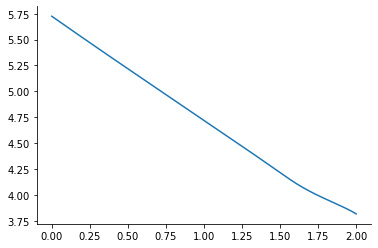

In [147]:
plt.plot(y_grid_short, model_res['v0'])

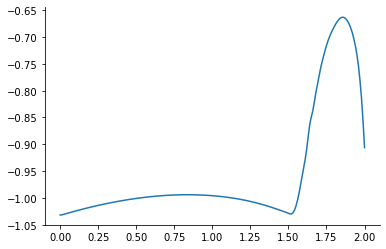

In [148]:
plt.plot(y_grid_short, model_res['v0_dy'])

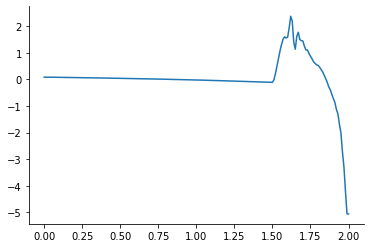

In [149]:
plt.plot(y_grid_short, model_res['v0_dyy'])

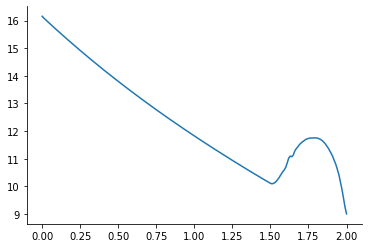

In [150]:
plt.plot(y_grid_short, model_res['e_tilde'])